# Overlap

Two types of plots are made in this figure:

1. UpSetPlot

Two UpSetPlots are created showing the overlap in spectrum_ids between spectra which were correctly predicted by the de novo tool and incorrectly predicted

2. Heatmap

The pairwise overlap is computed between two tools and shown in a heatmap. This will show the redundancy.

In [1]:
import os
from upsetplot import from_contents, plot
from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.io.read import load_pickle

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

import numpy as np
from itertools import permutations, combinations

2025-07-10 12:52:00.693205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-10 12:52:00.714094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-10 12:52:00.720331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


# 1. Load the data

In [3]:
# root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/denovo_output'
# root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
# root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
# run_names = [
#     'LFQ_Orbitrap_DDA_Ecoli_01',
#     'LFQ_Orbitrap_DDA_Human_01',
#     'LFQ_Orbitrap_DDA_QC_01',
#     'LFQ_Orbitrap_DDA_Yeast_01'
# ]

# engine_names = [
#     'adanovo',
#     'pihelixnovo',
#     'piprimenovo',
#     'casanovo',
#     'instanovo',
#     'contranovo',
#     'novob',
#     'pepnet',
# ]

# runs = {}
# for run_name in run_names:
#     print(f"Run: {run_name}")
#     run = Run(run_name)

#     mgf_path = os.path.join(root_mgf, run_name + '.mgf')

#     parser = DenovoEngineConverter.select('sage')
#     psmlist_gt = parser.parse(
#         result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
#         mgf_path=mgf_path
#     )
#     run.load_data(
#         psmlist=psmlist_gt.get_rank1_psms(),
#         score_names=[],
#         is_ground_truth=True
#     )

#     for engine_name in engine_names:
#         print(f'loading {engine_name}')
#         parser = DenovoEngineConverter.select(engine_name)
#         psmlist_denovo = parser.parse(
#             result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
#             mgf_path=mgf_path
#         )
#         run.load_data(
#             psmlist=psmlist_denovo,
#             score_names=[],
#             is_ground_truth=False
#         )
    
#     runs[run_name] = run

In [2]:
runs = load_pickle(
    '/home/sam/Work_directory/DeNovo_Benchmark/notebooks/paper/s1_performance_benchmark/run_objects_7_8.pickle'
)

In [3]:
runs['LFQ_Orbitrap_DDA_Ecoli_01'].spectra['controllerType=0 controllerNumber=1 scan=10014']

Spectrum ID: controllerType=0 controllerNumber=1 scan=10014
Ground-truth: LAQEASQE<AA>R/2 ({'peptide': {'sage': 2.7397043704986572, 'score_ms2rescore': 2.7397043704986572}, 'aa': {}})
Candidates:
	LAQEASAGE<AA>R/2 ({'peptide': {'AdaNovo': 0.9181580543518066, 'score_ms2rescore': 2.5012912759266137, 'Spectralis': -0.9695392307695376, 'InstaNovo+': -0.003537328215315938}, 'aa': {'AdaNovo': (0.46272, 0.95038, 0.95715, 0.9377, 0.95856, 0.95908, 0.95905, 0.95907, 0.95883, 0.95629, 0.95906, 0.95908)}})
	VYADT<ALM[UNIMOD:35]><GT>K/2 ({'peptide': {'pi-HelixNovo': 0.8100000023841858, 'score_ms2rescore': -8.30218178534406, 'Spectralis': -2.008333469505214, 'InstaNovo+': -0.01644195429980755}, 'aa': {}})
	LAQE<SQ>AE<AA>R/2 ({'peptide': {'pi-PrimeNovo': 0.0013102841330692172, 'score_ms2rescore': 1.7548339113503673, 'Spectralis': -1.5367428330958304, 'InstaNovo+': -0.00034771833452396095}, 'aa': {}})
	LAQEASQE<AA>R/2 ({'peptide': {'casanovo': 0.9010915756225586, 'score_ms2rescore': 2.739704253114398

In [4]:
error_matching = {}
for spectrum in runs['LFQ_Orbitrap_DDA_Ecoli_01'].spectra.values():
    for psm in spectrum.psm_candidates:
        try:
            match_dict = error_matching[psm.engine_name]
        except:
            error_matching[psm.engine_name] = {}
            match_dict = error_matching[psm.engine_name]
        
        try:
            match_dict[psm.evaluation['score_ms2rescore'].error_type].append(spectrum.spectrum_id)
        except:
            match_dict[psm.evaluation['score_ms2rescore'].error_type] = [spectrum.spectrum_id]

In [5]:
error_matching_count = {k: {k2: len(v2) for k2, v2 in v.items()} for k, v in error_matching.items()}

In [6]:
pd.DataFrame(error_matching_count).T

,match,No match - Not in FASTA,No match - In FASTA
AdaNovo,5974,9287,678
pi-HelixNovo,5941,9429,586
pi-PrimeNovo,6918,8258,543
casanovo,6780,8316,858
instanovo,6650,8662,651
novob,6068,9579,271
pepnet,4250,11399,333
contranovo,3366,4392,262


In [ ]:
# for run in runs.values():
#     for spectrum in run.spectra.values():
#         spectrum.compare_gt(
#             'sage',
#             ignore_score=True
#         )

## 2. Create spectrum_id lists

For correct predictions, spectrum-ids is enough.

For false predictions, peptidoforms need to be provided aswell.

In [7]:
denovo_engines = ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo', 'pi-PrimeNovo', 'AdaNovo', 'pi-HelixNovo']
denovo_engines_selection = [
    'casanovo',
    'novob',
    'instanovo',
    'pi-PrimeNovo',
    'AdaNovo',
    'pi-HelixNovo'
]

In [8]:
correct_by_engine = {engine: [] for engine in denovo_engines}
for run_name, run in runs.items():
    for engine in denovo_engines:
        run_engine = run.get_common_spectra(engines=[engine])
        for specid, spectrum in run_engine.spectra.items():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['score_ms2rescore'].error_type=='match':
                correct_by_engine[engine].append(
                    f'{run_name}_{specid}_{psm.peptidoform.proforma}'
                )

false_by_engine = {engine: [] for engine in denovo_engines}
for run_name, run in runs.items():
    for engine in denovo_engines:
        run_engine = run.get_common_spectra(engines=[engine])
        for specid, spectrum in run_engine.spectra.items():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['score_ms2rescore'].error_type!='match':
                false_by_engine[engine].append(
                    f'{run_name}_{specid}_{psm.peptidoform.proforma}'
                )

all_by_engine = {engine: [] for engine in denovo_engines}
for run_name, run in runs.items():
    for engine in denovo_engines:
        run_engine = run.get_common_spectra(engines=[engine])
        for specid, spectrum in run_engine.spectra.items():
            psm = spectrum.get_psms_by_engine(engine)[0]
            all_by_engine[engine].append(
                f'{run_name}_{specid}_{psm.peptidoform.proforma}'
            )

In [9]:
upset_data_correct = from_contents(correct_by_engine)
upset_data_false = from_contents(false_by_engine)

In [10]:
upset_data_correct_reindexed = upset_data_correct.reset_index()
upset_data_correct_reindexed['n_correct'] = upset_data_correct_reindexed[denovo_engines].sum(axis=1)
upset_data_correct_reindexed['spectrum_id'] = upset_data_correct_reindexed['id'].apply(
    lambda x: '_'.join(x.split('_')[:-1])
)

upset_data_false_reindexed = upset_data_false.reset_index()
upset_data_false_reindexed['n_false'] = upset_data_false_reindexed[denovo_engines].sum(axis=1)
upset_data_false_reindexed['spectrum_id'] = upset_data_false_reindexed['id'].apply(
    lambda x: '_'.join(x.split('_')[:-1])
)

In [11]:
n_spectra = len(pd.Series(
    upset_data_false_reindexed['spectrum_id'].tolist() + 
    upset_data_correct_reindexed['spectrum_id'].tolist()
).drop_duplicates())

n_spectra_correct = upset_data_correct_reindexed['spectrum_id'].nunique()

#### % Correct predictions

% on all spectra

In [12]:
(upset_data_correct_reindexed['n_correct'].value_counts() / n_spectra *100).sort_index()

1     9.444334
2     7.113342
3     6.636719
4     6.548595
5     6.864552
6     8.882811
7    13.680743
8     8.764058
Name: n_correct, dtype: float64

% on the spectra being correctly predicted by at least one model

In [13]:
(upset_data_correct_reindexed['n_correct'].value_counts() / n_spectra_correct *100).sort_index()

1    13.901984
2    10.470782
3     9.769197
4     9.639479
5    10.104565
6    13.075426
7    20.137944
8    12.900623
Name: n_correct, dtype: float64

In [14]:
upset_data_correct_reindexed[
    upset_data_correct_reindexed[
        denovo_engines_selection
    ].sum(axis=1)>=6
]['id'].nunique() / n_spectra

0.2360599889307419

Excluding ContraNovo and PepNet

In [26]:
upset_data_correct_reindexed[
    upset_data_correct_reindexed[
        denovo_engines_selection
    ].sum(axis=1)>=6
]['id'].nunique() / n_spectra_correct

0.3474784066820641

Uniquely correct

In [16]:
for engine in denovo_engines:
    n = len(upset_data_correct_reindexed[
        (upset_data_correct_reindexed['n_correct']==1) &
        (upset_data_correct_reindexed[engine])
    ]) / n_spectra_correct
    print('{}: \t{:.3f}'.format(engine, n*100))

casanovo: 	0.882
novob: 	3.252
instanovo: 	3.148
pepnet: 	0.258
contranovo: 	1.389
pi-PrimeNovo: 	3.664
AdaNovo: 	0.927
pi-HelixNovo: 	0.383


In [17]:
for engine in denovo_engines:
    n = len(upset_data_correct_reindexed[
        (upset_data_correct_reindexed['n_correct']==1) &
        (upset_data_correct_reindexed[engine])
    ]) / n_spectra
    print('{}: \t{:.3f}'.format(engine, n*100))

casanovo: 	0.599
novob: 	2.209
instanovo: 	2.139
pepnet: 	0.175
contranovo: 	0.944
pi-PrimeNovo: 	2.489
AdaNovo: 	0.630
pi-HelixNovo: 	0.260


In [18]:
n_spectra_correct/n_spectra

0.6793515349192105

#### % of aggreement for false identifications over all spectra

In [19]:
upset_data_false_reindexed[upset_data_false_reindexed['n_false']>=8]['id'].nunique() / n_spectra

0.0037506515279337564

## 2.1. Correct spectra

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

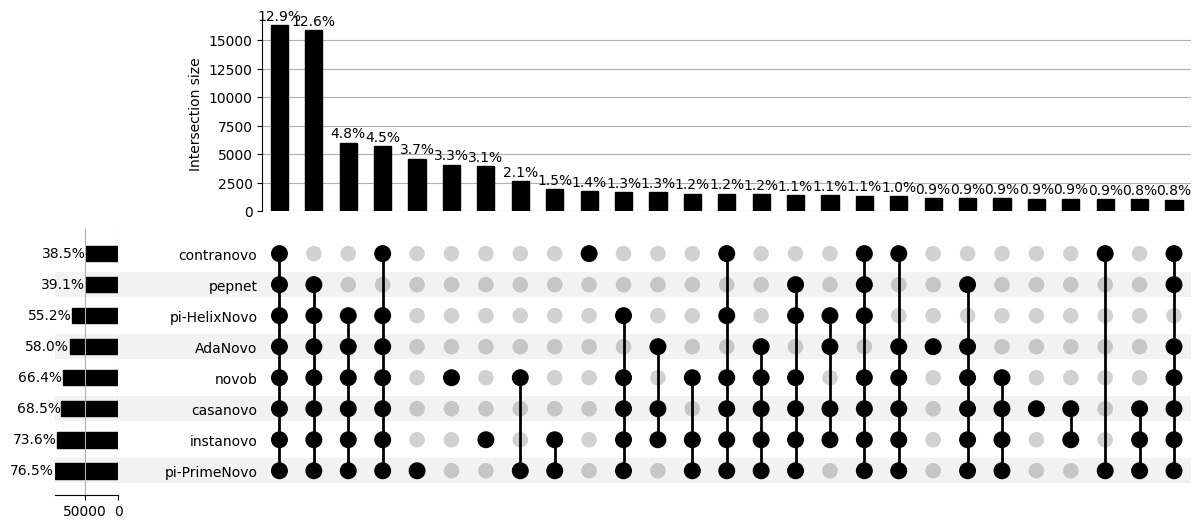

In [20]:
plot(upset_data_correct, sort_by='cardinality', show_percentages=True, min_subset_size=1000)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

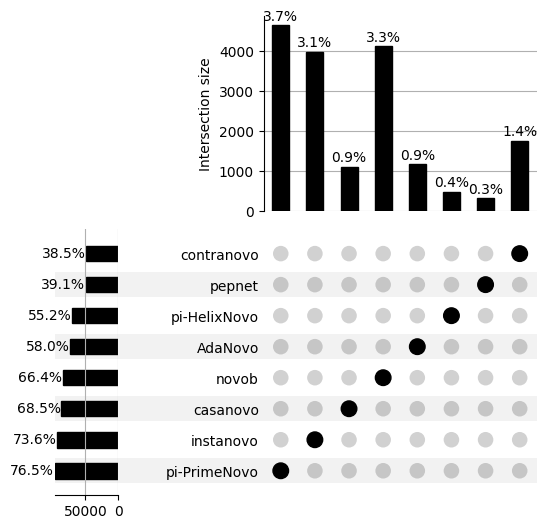

In [21]:
plot(
    upset_data_correct,
    min_degree=1, max_degree=1, show_percentages=True
)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

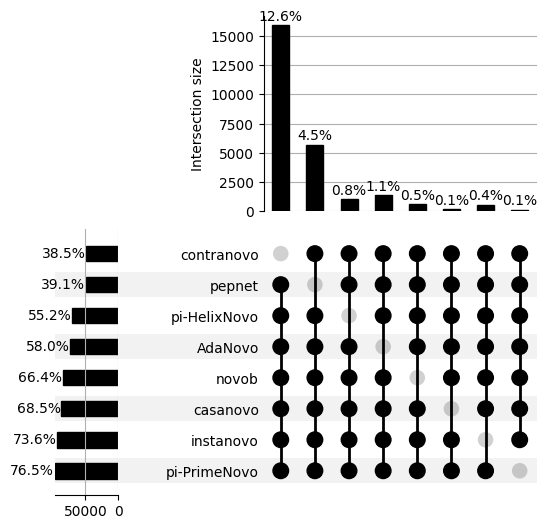

In [22]:
plot(
    upset_data_correct,
    min_degree=7, max_degree=7, show_percentages=True
)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

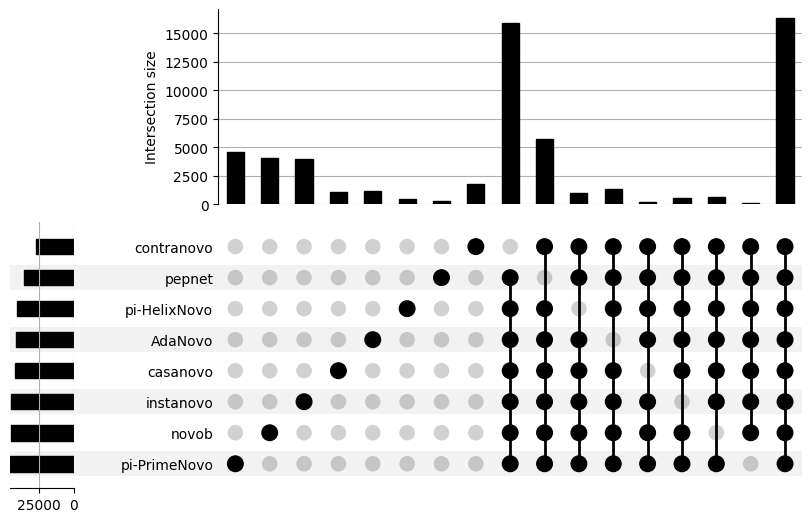

In [27]:
plot(upset_data_correct.loc[
    (upset_data_correct.reset_index().sum(axis=1)>6).to_numpy() |
    (upset_data_correct.reset_index().sum(axis=1)==1).to_numpy()
])

## 2.2 False spectra

Necessary ?

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

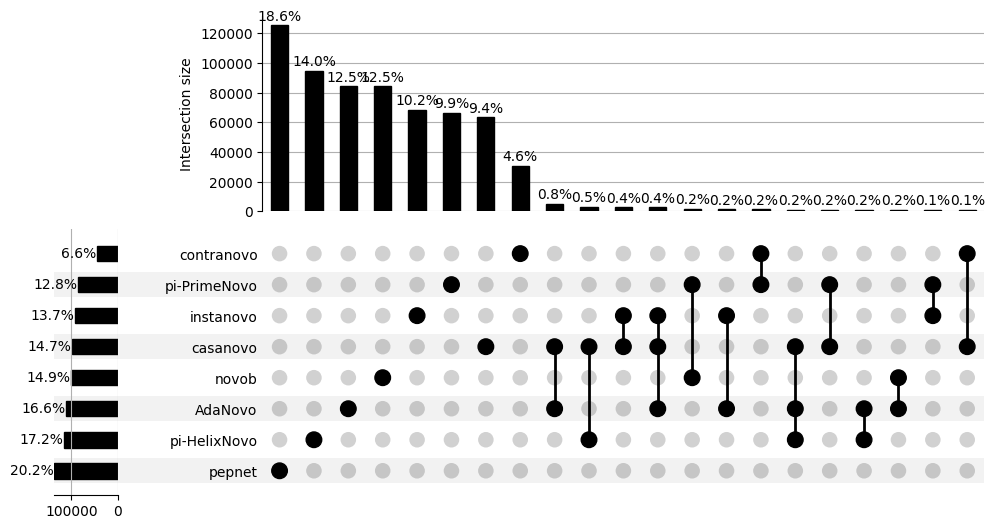

In [28]:
plot(upset_data_false, sort_by='cardinality', show_percentages=True, min_subset_size=1000)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

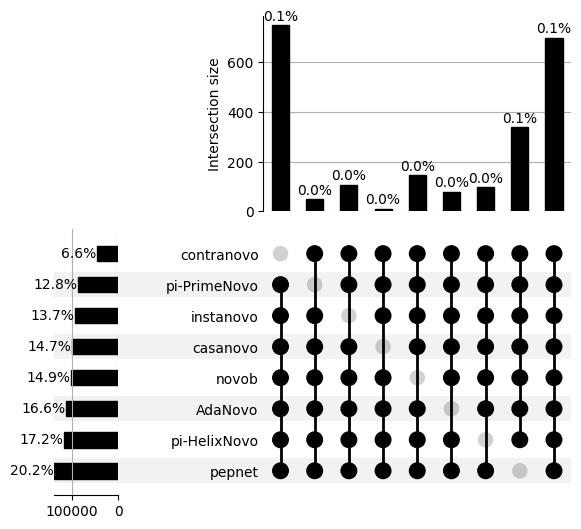

In [29]:
plot(
    upset_data_false,
    min_degree=7, max_degree=8, show_percentages=True
)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

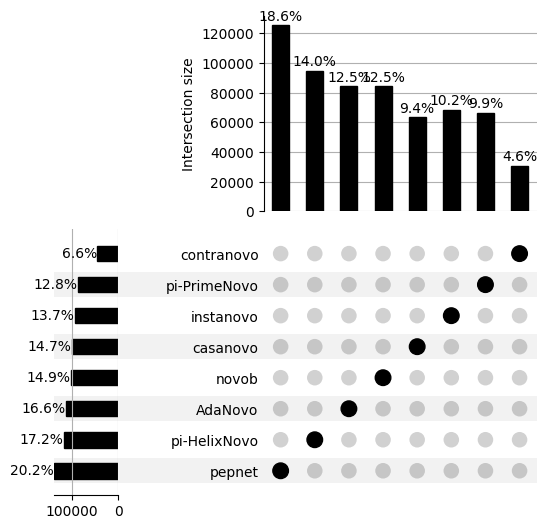

In [30]:
plot(
    upset_data_false,
    min_degree=1, max_degree=1, show_percentages=True
)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

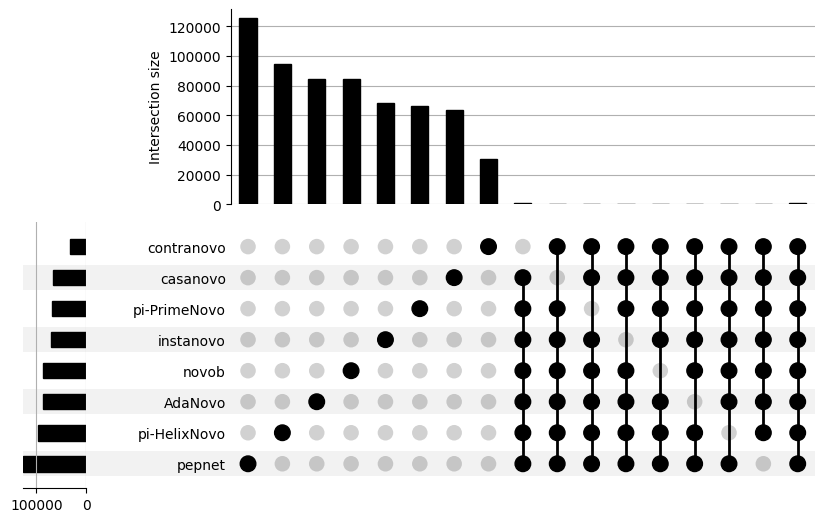

In [31]:
plot(upset_data_false.loc[
    (upset_data_false.reset_index().sum(axis=1)>6).to_numpy() |
    (upset_data_false.reset_index().sum(axis=1)==1).to_numpy()
])

# 3. Pairwise overlaps Heatmaps

2 heatmaps: Only correct ones and only false ones ?

In [32]:
def get_overlap(list1, list2):
    set_1, set_2 = set(list1), set(list2)
    intersection = set_1.intersection(set_2)

    if len(set_1) == 0:
        overlap_tool_1 = 0
    else:
        overlap_tool_1 = len(intersection) / len(set_1)
    if len(set_2) == 0:
        overlap_tool_2 = 0
    else:
        overlap_tool_2 = len(intersection) / len(set_2)

    return overlap_tool_1, overlap_tool_2

In [33]:
def get_overlap_matrix(dict_of_lists, denovo_engines):
    overlap_matrix = np.ones((len(denovo_engines), len(denovo_engines)))

    for (engine_1, engine_2) in combinations(denovo_engines, 2):
        i = denovo_engines.index(engine_1)
        j = denovo_engines.index(engine_2)
        overlap_1, overlap_2 = get_overlap(
            dict_of_lists[engine_1],
            dict_of_lists[engine_2]
        )
        overlap_matrix[i, j] = overlap_1
        overlap_matrix[j, i] = overlap_2
    return overlap_matrix

In [34]:
all_overlap_matrix = get_overlap_matrix(all_by_engine, denovo_engines=denovo_engines)
correct_overlap_matrix = get_overlap_matrix(correct_by_engine, denovo_engines=denovo_engines)
false_overlap_matrix = get_overlap_matrix(false_by_engine, denovo_engines=denovo_engines)

<Axes: >

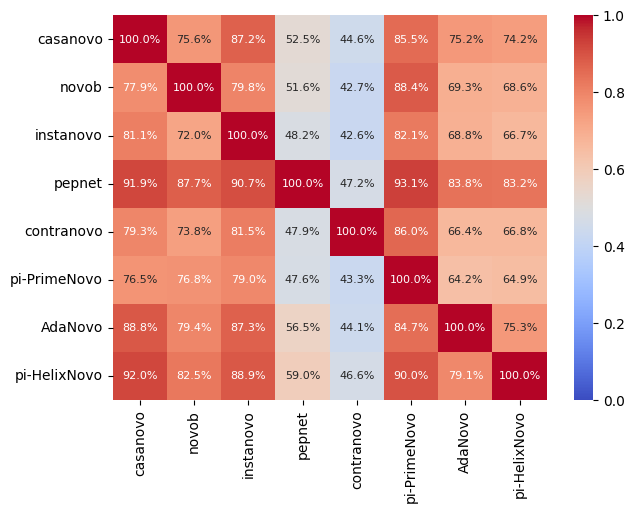

In [35]:
plt.figure(figsize=(7,5))
sns.heatmap(
    correct_overlap_matrix,
    annot=True,
    cmap="coolwarm",
    xticklabels=denovo_engines,
    yticklabels=denovo_engines,
    vmin=0,
    vmax=1,
    fmt=".1%",
    annot_kws={"size": 8}
)

<Axes: >

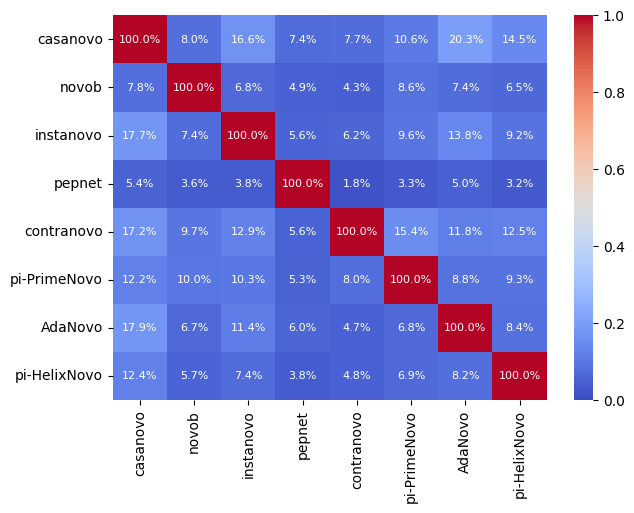

In [36]:
plt.figure(figsize=(7,5))
sns.heatmap(
    false_overlap_matrix,
    annot=True,
    cmap="coolwarm",
    xticklabels=denovo_engines,
    yticklabels=denovo_engines,
    vmin=0,
    vmax=1,
    fmt=".1%",
    annot_kws={"size": 8}
)

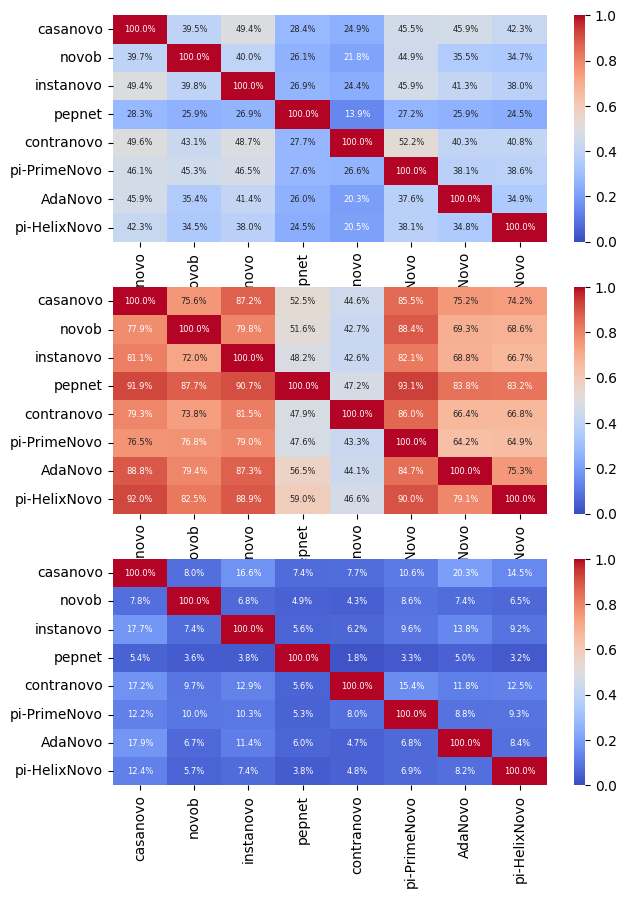

In [37]:
fig, ax = plt.subplots(3,1, figsize=(7,10))
for i, om in enumerate([all_overlap_matrix, correct_overlap_matrix, false_overlap_matrix]):
    sns.heatmap(
        om,
        annot=True,
        cmap="coolwarm",
        xticklabels=denovo_engines,
        yticklabels=denovo_engines,
        ax=ax[i],
        vmin=0,
        vmax=1,
        fmt=".1%",
        annot_kws={"size": 6}
    )

## Check if all overlapping, yet false predictions are in the FASTA

In [38]:
common_in_fasta = {}

for num_common in range(5,9):

    common_false_ids = upset_data_false[(upset_data_false.reset_index().sum(axis=1) >= num_common).to_numpy()]['id'].tolist()

    common_false_specids = [('_'.join(i.split('_')[:-2]), i.split('_')[-2]) for i in common_false_ids]

    match_types_all_false = {}
    for (run_name, specid) in common_false_specids:
        spectrum = runs[run_name].get_spectrum(specid)
        error_types = {}
        for psm in spectrum.psm_candidates:
            try:
                error_types[psm.evaluation['score_ms2rescore'].error_type] += 1
            except:
                error_types[psm.evaluation['score_ms2rescore'].error_type] = 1
            
        error_type = max(error_types, key=error_types.get)
        
        match_types_all_false['|'.join([run_name, specid])] = [error_type]

    common_in_fasta[num_common] = pd.DataFrame(match_types_all_false).T.value_counts(normalize=True)


In [39]:
pd.DataFrame(common_in_fasta)

,5,6,7,8
0,,,,
No match - In FASTA,0.625575,0.697239,0.760563,0.812321
No match - Not in FASTA,0.374425,0.302761,0.239437,0.187679


# Supplementary figures

Plot some annotated spectra which are commonly identified by all models

In [40]:
specids_all_false = pd.DataFrame(upset_data_false_reindexed[upset_data_false_reindexed['n_false']>=8]['id'].unique()).rename(
    columns={0: 'code'}
)
specids_all_false['run'] = specids_all_false.apply(lambda x: x['code'].split('_controller')[0], axis=1)
specids_all_false['specid'] = specids_all_false.apply(lambda x: 'controller' + '_'.join(x['code'].split('_controller')[1].split('_')[:-1]), axis=1)
specids_all_false.head(3)

,code,run,specid
0,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=68814
1,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=50248
2,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=44300


In [41]:
import spectrum_utils.plot as sup
from denovo_utils.analysis.visualization import plot_spectrum


def create_mirror(root, run_name, specid, pep_1, pep_2):

    plot_1 = plot_spectrum(
        peak_path=os.path.join(root, run_name),
        spectrum_id=specid,
        peptide=pep_1,
        peak_format='mgf',
        plot=False
    )
    plot_2 = plot_spectrum(
        peak_path=os.path.join(root, run_name),
        spectrum_id=specid,
        peptide=pep_2,
        peak_format='mgf',
        plot=False
    )
    return plot_1, plot_2

In [42]:
specids_all_false

,code,run,specid
0,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=68814
1,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=50248
2,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=44300
3,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=26564
4,LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Ecoli_01,controllerType=0 controllerNumber=1 scan=52255
...,...,...,...
693,LFQ_Orbitrap_DDA_Yeast_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Yeast_01,controllerType=0 controllerNumber=1 scan=11540
694,LFQ_Orbitrap_DDA_Yeast_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Yeast_01,controllerType=0 controllerNumber=1 scan=43152
695,LFQ_Orbitrap_DDA_Yeast_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Yeast_01,controllerType=0 controllerNumber=1 scan=54892
696,LFQ_Orbitrap_DDA_Yeast_01_controllerType=0 con...,LFQ_Orbitrap_DDA_Yeast_01,controllerType=0 controllerNumber=1 scan=33202


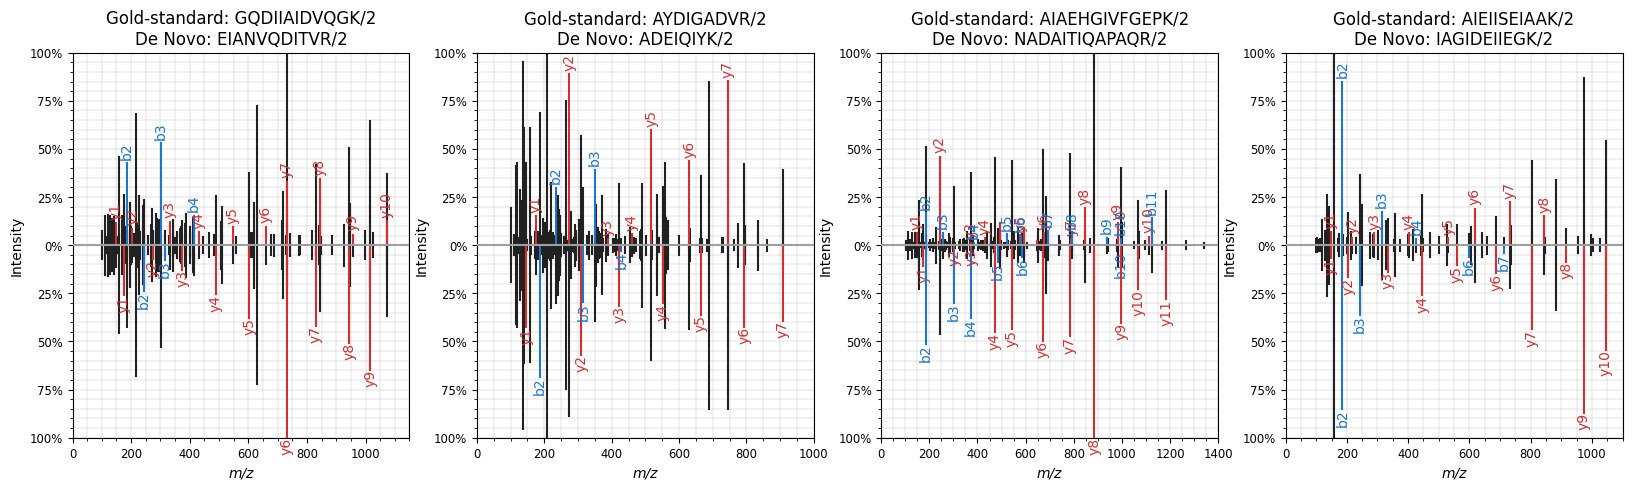

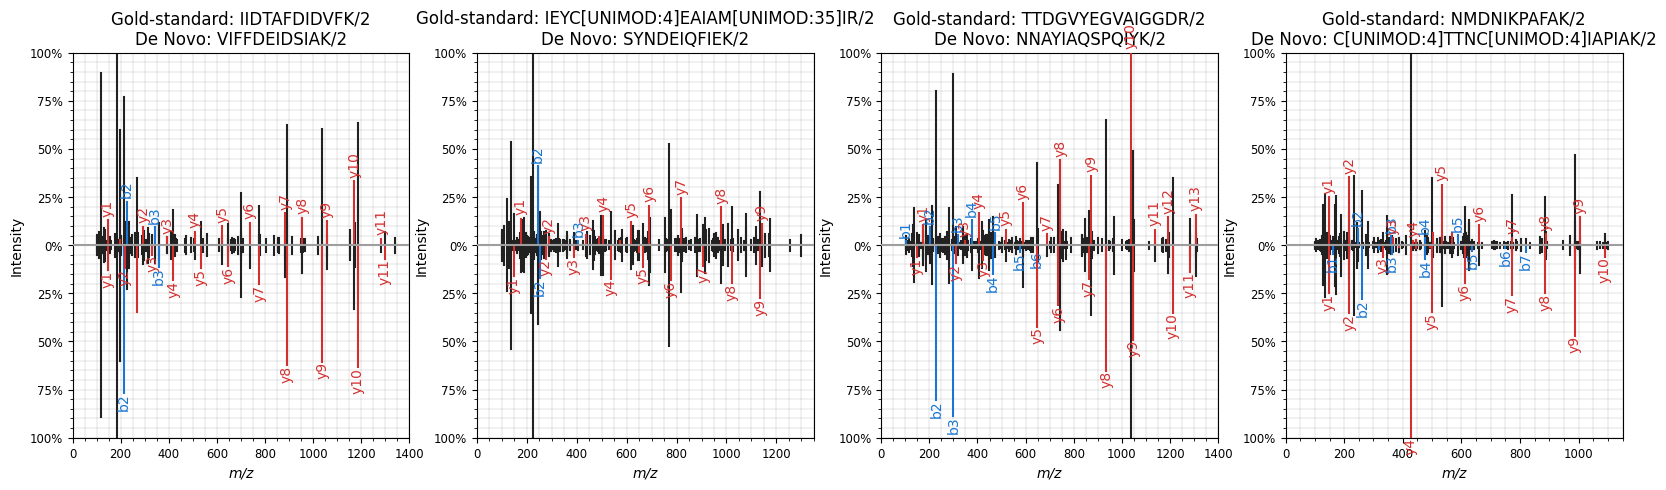

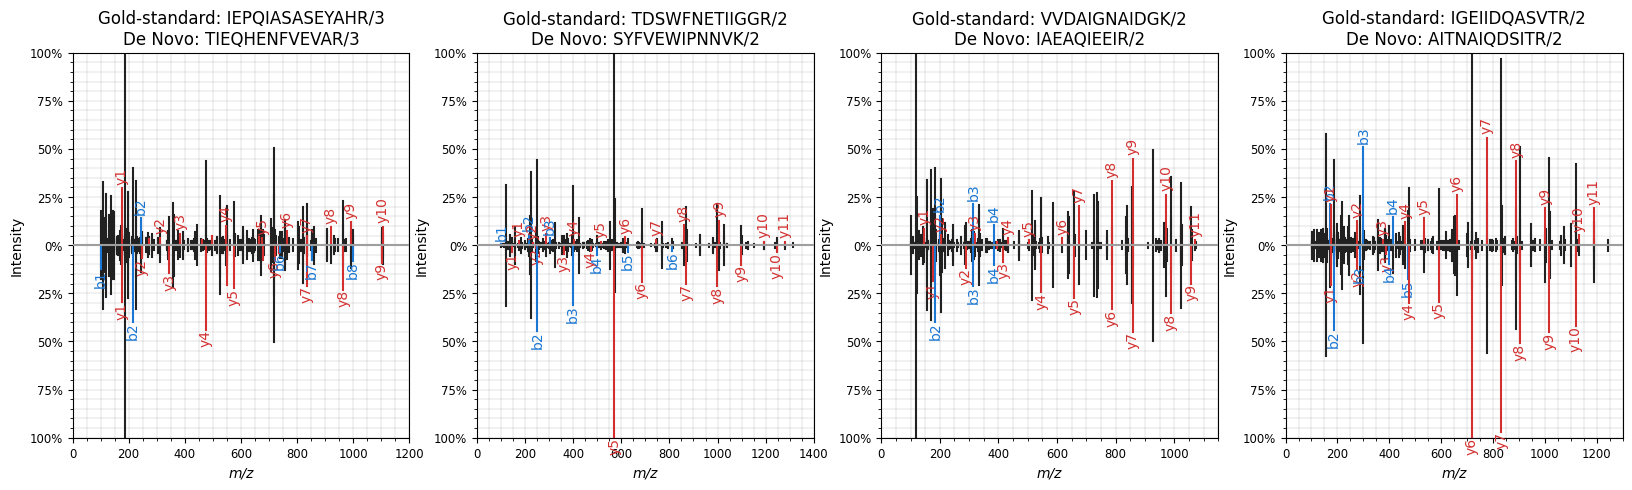

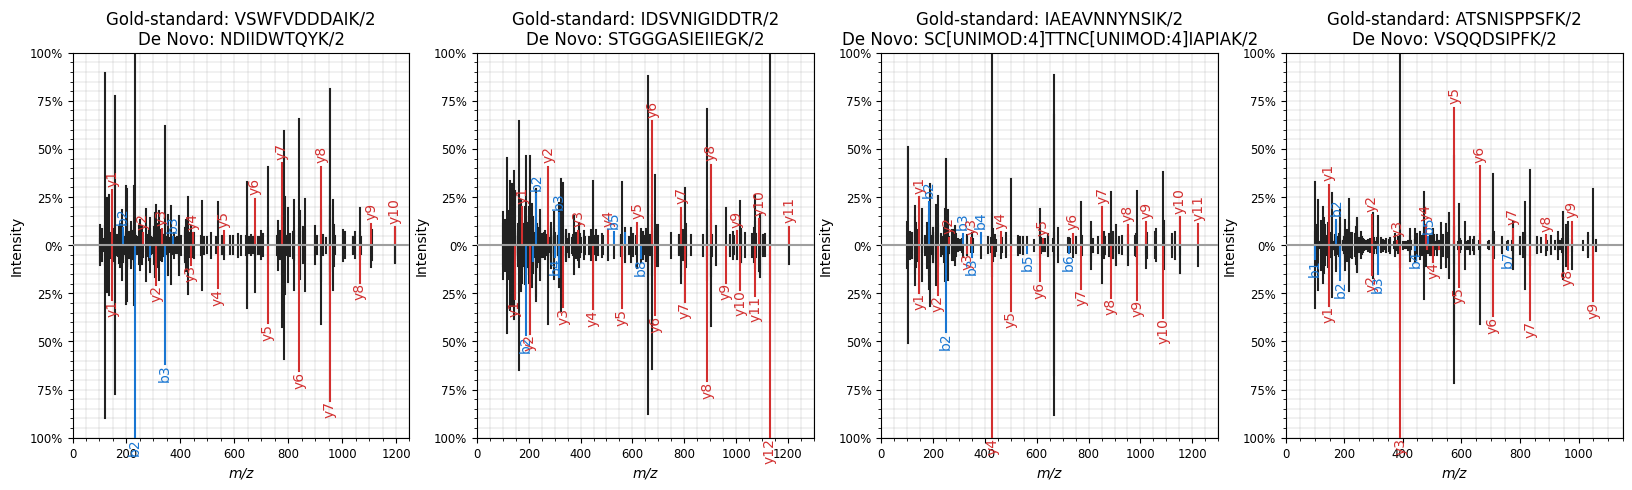

In [45]:

for run_name, run in runs.items():
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    i = 0
    for specid in specids_all_false[specids_all_false['run']==run_name]['specid'].tolist():
        spectrum = run.get_spectrum(specid)
        
        if spectrum.psm_candidates[0].evaluation['score_ms2rescore'].error_type != 'No match - In FASTA':
            continue

        p1, p2 = create_mirror(
            root='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted',
            run_name=f'{run_name}.mgf',
            specid=specid,
            pep_1=spectrum.psm_gt.peptidoform.proforma,
            pep_2=spectrum.psm_candidates[0].peptidoform.proforma
        )
        sup.mirror(p1,p2, ax=ax[i])
        ax[i].set_title(f'Gold-standard: {spectrum.psm_gt.peptidoform.proforma}\nDe Novo: {spectrum.psm_candidates[0].peptidoform.proforma}')
        i += 1
        if i == 4:
            break
    fig.show()

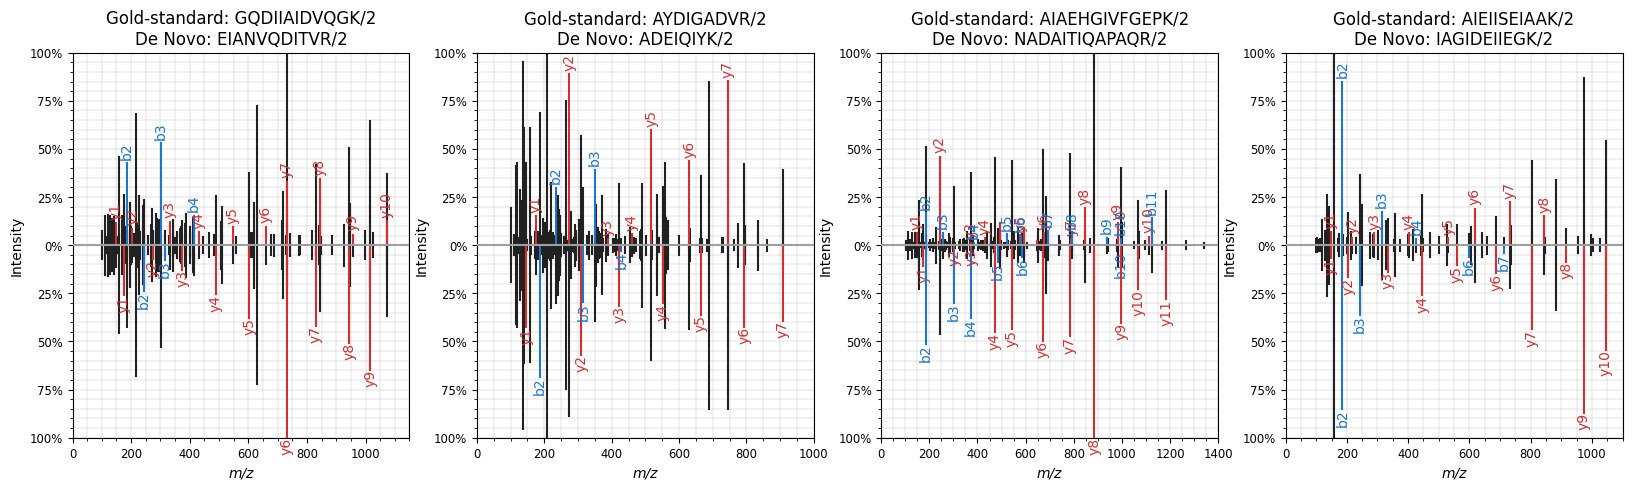

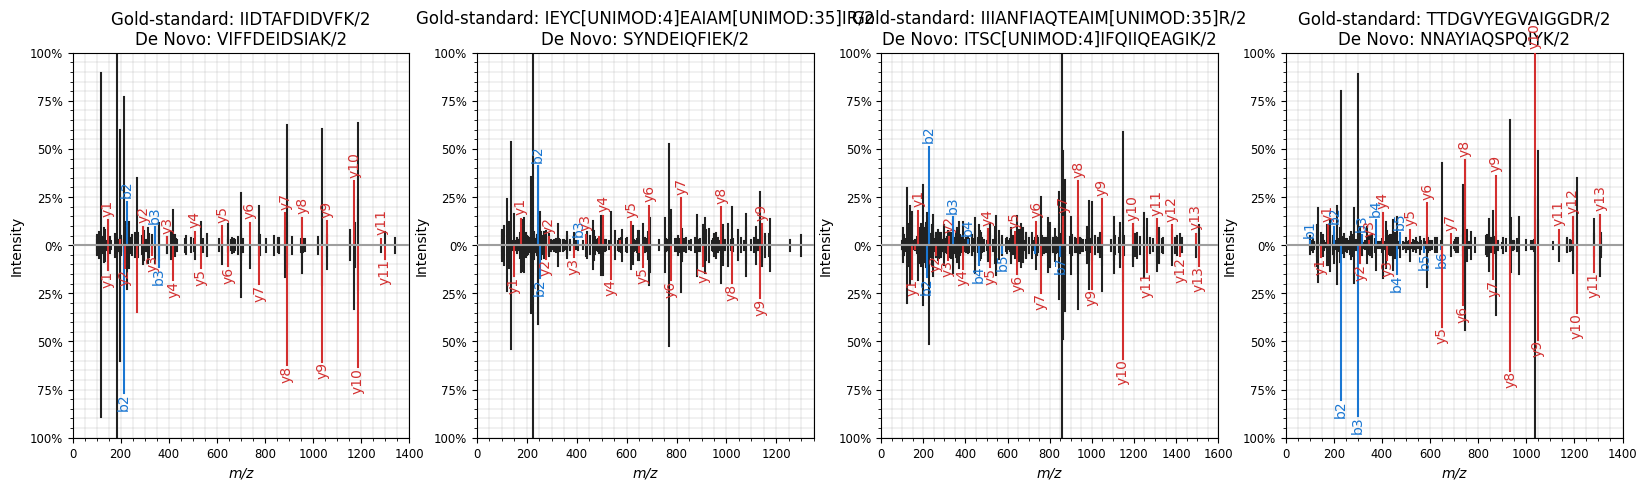

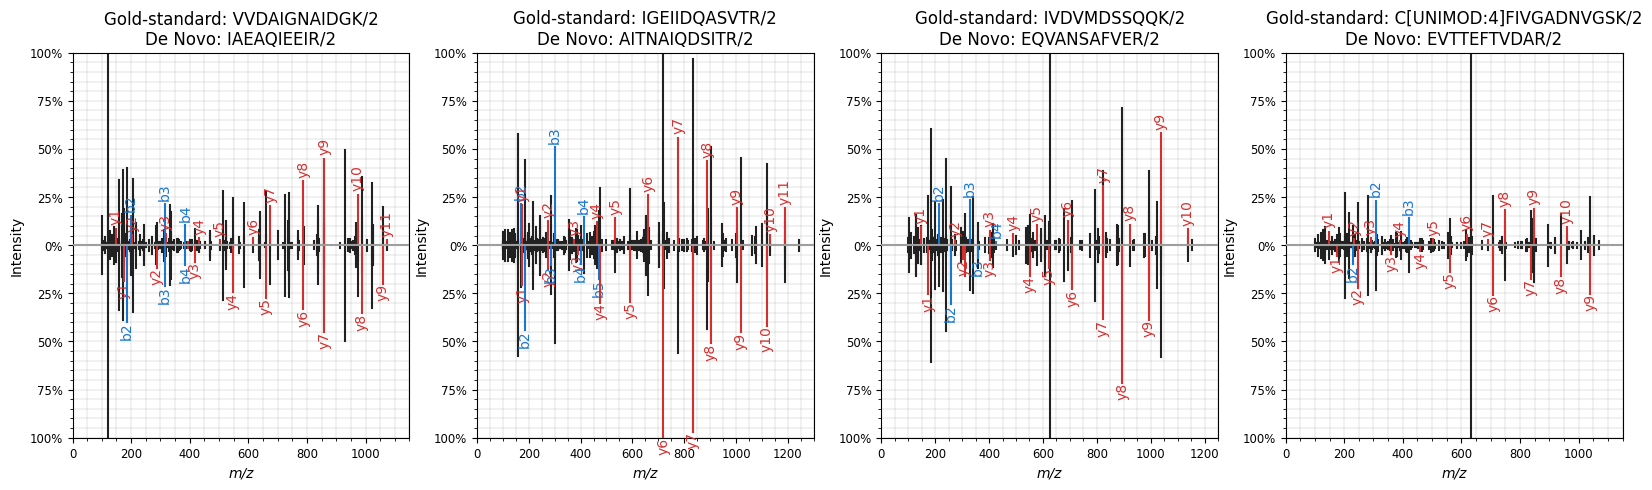

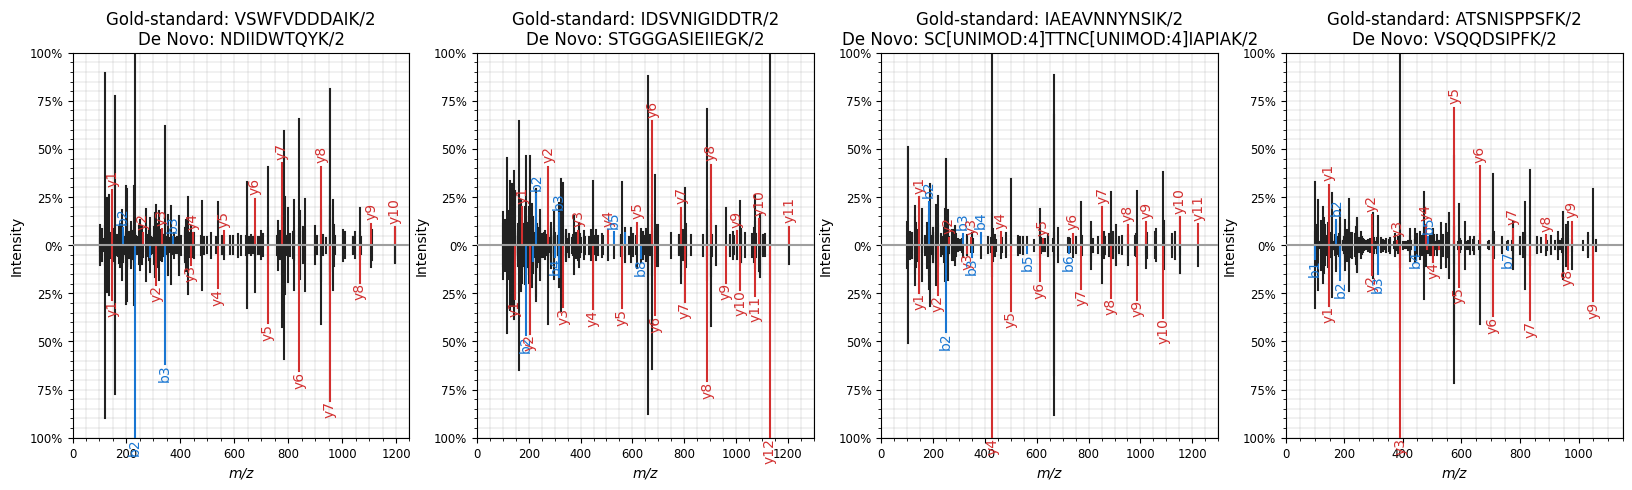

In [107]:

for run_name, run in runs.items():
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    i = 0
    for specid in specids_all_false[specids_all_false['run']==run_name]['specid'].tolist():
        spectrum = run.get_spectrum(specid)
        
        if spectrum.psm_candidates[0].evaluation['score_ms2rescore'].error_type != 'No match - In FASTA':
            continue

        p1, p2 = create_mirror(
            root='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted',
            run_name=f'{run_name}.mgf',
            specid=specid,
            pep_1=spectrum.psm_gt.peptidoform.proforma,
            pep_2=spectrum.psm_candidates[0].peptidoform.proforma
        )
        sup.mirror(p1,p2, ax=ax[i])
        ax[i].set_title(f'Gold-standard: {spectrum.psm_gt.peptidoform.proforma}\nDe Novo: {spectrum.psm_candidates[0].peptidoform.proforma}')
        i += 1
        if i == 4:
            break
    fig.show()